In [11]:
import os
import sys
sys.path.append("..")

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from trace_analyzer import TraceAnalyzer

sim_result_root = "../sim_result"


In [12]:
def get_real_tile_latency(trace_analyzer: TraceAnalyzer, layer:int, batch:int):
    graph = trace_analyzer.graph.get_graph()

    G = graph.subgraph(nodes=[n for n, nattr in graph.nodes(data=True)
        if nattr["layer"] == layer
        and nattr["batch"] == batch
        ])

    assert len(G.nodes) > 0

    wsrc = [n for n, attr in G.nodes(data=True) if attr["op_type"] == "wsrc"]
    assert len(wsrc) == 1
    wsrc = wsrc[0]
    insrc = [n for n, attr in G.nodes(data=True) if attr["op_type"] == "insrc"]
    assert len(insrc) == 1
    insrc = insrc[0]
    workers = [n for n, attr in G.nodes(data=True) if attr["op_type"] == "worker"]
    # sink = [n for n, attr in G.nodes(data=True) if attr["op_type"] == "sink"][0]

    w_cnt = int(G.nodes[wsrc]["cnt"])
    in_cnt = int(G.nodes[insrc]["cnt"])
    w_start = [float("inf")] * w_cnt
    w_end = [-float("inf")] * w_cnt
    in_start = [float("inf")] * in_cnt
    in_end = [-float("inf")] * in_cnt

    for w in workers:
        w_edges = G.edges[wsrc, w]["pkt"]
        w_pids = sorted(list(w_edges.keys()))

        in_edges = G.edges[insrc, w]["pkt"]
        in_pids = sorted(list(in_edges.keys()))

        for t in range(w_cnt):
            w_pkt = w_edges[w_pids[t]]
            w_start[t] = min(w_start[t], w_pkt["start_cycle"])
            w_end[t] = max(w_end[t], w_pkt["end_cycle"])

        for t in range(in_cnt):
            in_pkt = in_edges[in_pids[t]]
            in_start[t] = min(in_start[t], in_pkt["start_cycle"])
            in_end[t] = max(in_end[t], in_pkt["end_cycle"])

    # align different cnts
    if w_cnt > in_cnt:
        ratio = w_cnt // in_cnt
        w_latency = {i: l[1]-l[0] for i, l in enumerate(zip(w_start, w_end))}
        in_latency = {ratio*i: l[1]-l[0] for i, l in enumerate(zip(in_start, in_end))}
    elif w_cnt < in_cnt:
        ratio = in_cnt // w_cnt
        w_latency = {ratio*i: l[1]-l[0] for i, l in enumerate(zip(w_start, w_end))}
        in_latency = {i: l[1]-l[0] for i, l in enumerate(zip(in_start, in_end))}
    else:
        w_latency = {i: l[1]-l[0] for i, l in enumerate(zip(w_start, w_end))}
        in_latency = {i: l[1]-l[0] for i, l in enumerate(zip(in_start, in_end))}

    return w_latency, in_latency


def get_cnt(trace_analyzer:TraceAnalyzer, layer, batch):
    graph = trace_analyzer.graph.get_graph()

    G = graph.subgraph(nodes=[n for n, nattr in graph.nodes(data=True)
        if nattr["layer"] == layer
        and nattr["batch"] == batch
        ])

    assert len(G.nodes) > 0

    wsrc = [n for n, attr in G.nodes(data=True) if attr["op_type"] == "wsrc"]
    assert len(wsrc) == 1
    wsrc = wsrc[0]
    insrc = [n for n, attr in G.nodes(data=True) if attr["op_type"] == "insrc"]
    assert len(insrc) == 1
    insrc = insrc[0]
    workers = [n for n, attr in G.nodes(data=True) if attr["op_type"] == "worker"]

    w_cnt = int(G.nodes[wsrc]["cnt"])
    in_cnt = int(G.nodes[insrc]["cnt"])
    worker_cnt = int(G.nodes[workers[0]]["cnt"])

    res = {
        "w_cnt": w_cnt,
        "in_cnt": in_cnt,
        "worker_cnt": worker_cnt,
    }
    return res

def get_delay(trace_analyzer: TraceAnalyzer, layer, batch):
    graph = trace_analyzer.graph.get_graph()

    G = graph.subgraph(nodes=[n for n, nattr in graph.nodes(data=True)
        if nattr["layer"] == layer
        and nattr["batch"] == batch
        ])

    assert len(G.nodes) > 0

    wsrc = [n for n, attr in G.nodes(data=True) if attr["op_type"] == "wsrc"]
    assert len(wsrc) == 1
    wsrc = wsrc[0]
    insrc = [n for n, attr in G.nodes(data=True) if attr["op_type"] == "insrc"]
    assert len(insrc) == 1
    insrc = insrc[0]
    workers = [n for n, attr in G.nodes(data=True) if attr["op_type"] == "worker"]

    res = {
        "wsrc": G.nodes[wsrc]["delay"],
        "insrc": G.nodes[insrc]["delay"],
        "worker": G.nodes[workers[0]]["delay"],
    }
    return res

bert_6_b1w1024_8x8
bert_4_b1w1024_8x8
inception_8_b1w1024_8x8
inception_layer1
wsrc cnt: 2738; insrc cnt: 1369; worker cnt: 2738
wsrc delay: 27.0; insrc delay: 54.0; worker delay: 27.0


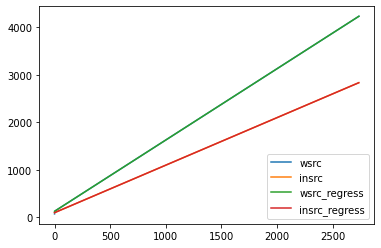

inception_layer10
wsrc cnt: 600; insrc cnt: 25; worker cnt: 600
wsrc delay: 150.0; insrc delay: 3600.0; worker delay: 150.0


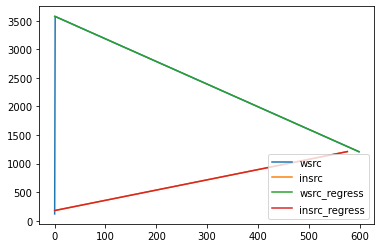

inception_layer11
wsrc cnt: 600; insrc cnt: 25; worker cnt: 600
wsrc delay: 225.0; insrc delay: 5400.0; worker delay: 225.0


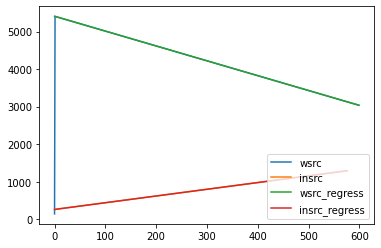

inception_layer12
wsrc cnt: 4; insrc cnt: 1; worker cnt: 4
wsrc delay: 1875.0; insrc delay: 7500.0; worker delay: 1875.0


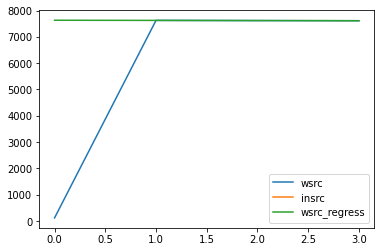

inception_layer13
wsrc cnt: 500; insrc cnt: 500; worker cnt: 250
wsrc delay: 40.0; insrc delay: 40.0; worker delay: 80.0


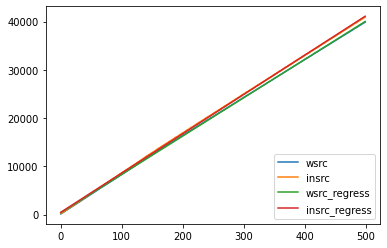

inception_layer14
wsrc cnt: 2000; insrc cnt: 2000; worker cnt: 250
wsrc delay: 5.0; insrc delay: 5.0; worker delay: 40.0


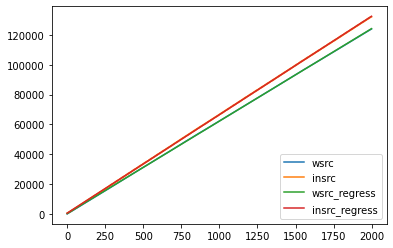

inception_layer15
wsrc cnt: 1000; insrc cnt: 1000; worker cnt: 1000
wsrc delay: 150.0; insrc delay: 150.0; worker delay: 150.0


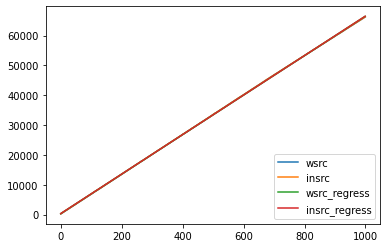

inception_layer16
wsrc cnt: 200; insrc cnt: 200; worker cnt: 50
wsrc delay: 100.0; insrc delay: 100.0; worker delay: 400.0


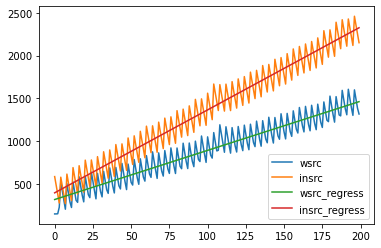

inception_layer17
wsrc cnt: 600; insrc cnt: 25; worker cnt: 600
wsrc delay: 150.0; insrc delay: 3600.0; worker delay: 150.0


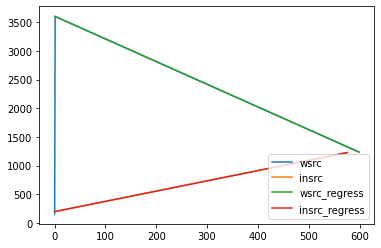

inception_layer18
wsrc cnt: 600; insrc cnt: 25; worker cnt: 600
wsrc delay: 225.0; insrc delay: 5400.0; worker delay: 225.0


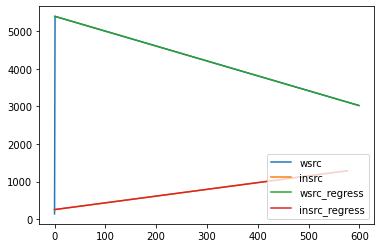

inception_layer19
wsrc cnt: 200; insrc cnt: 200; worker cnt: 50
wsrc delay: 100.0; insrc delay: 100.0; worker delay: 400.0


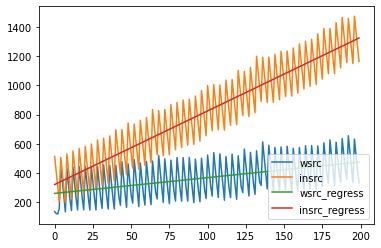

inception_layer2
wsrc cnt: 1; insrc cnt: 109; worker cnt: 109
wsrc delay: 142572.0; insrc delay: 1308.0; worker delay: 1308.0


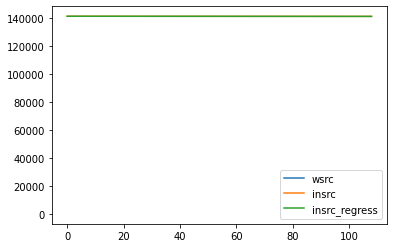

inception_layer20
wsrc cnt: 450; insrc cnt: 450; worker cnt: 50
wsrc delay: 25.0; insrc delay: 25.0; worker delay: 225.0


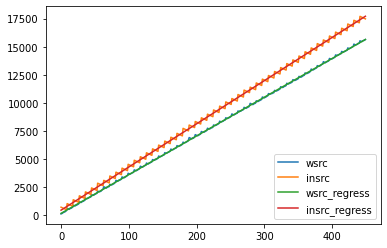

inception_layer21
wsrc cnt: 4; insrc cnt: 1; worker cnt: 4
wsrc delay: 3750.0; insrc delay: 15000.0; worker delay: 3750.0


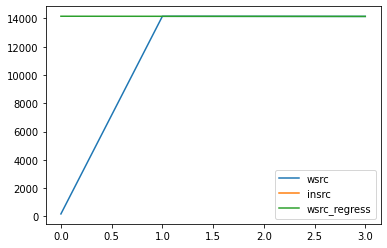

inception_layer22
wsrc cnt: 1000; insrc cnt: 1000; worker cnt: 1000
wsrc delay: 150.0; insrc delay: 150.0; worker delay: 150.0


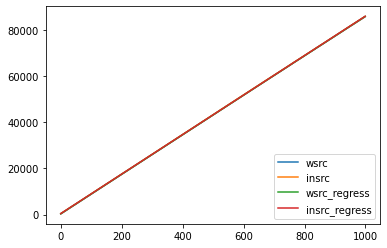

inception_layer23
wsrc cnt: 450; insrc cnt: 450; worker cnt: 50
wsrc delay: 25.0; insrc delay: 25.0; worker delay: 225.0


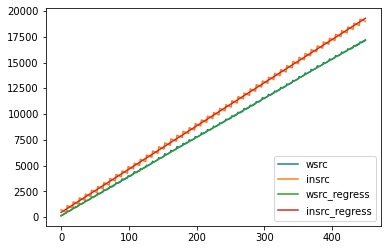

inception_layer24
wsrc cnt: 600; insrc cnt: 25; worker cnt: 600
wsrc delay: 150.0; insrc delay: 3600.0; worker delay: 150.0


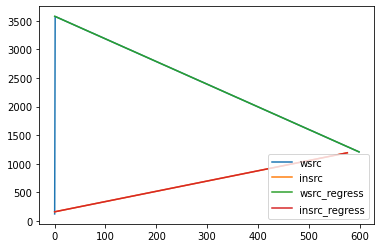

inception_layer25
wsrc cnt: 600; insrc cnt: 25; worker cnt: 600
wsrc delay: 225.0; insrc delay: 5400.0; worker delay: 225.0


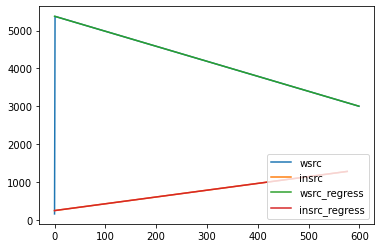

inception_layer26
wsrc cnt: 450; insrc cnt: 450; worker cnt: 50
wsrc delay: 25.0; insrc delay: 25.0; worker delay: 225.0


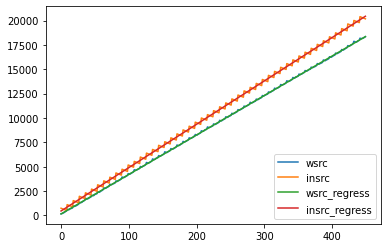

inception_layer27
wsrc cnt: 72; insrc cnt: 72; worker cnt: 4
wsrc delay: 2592.0; insrc delay: 2592.0; worker delay: 46656.0


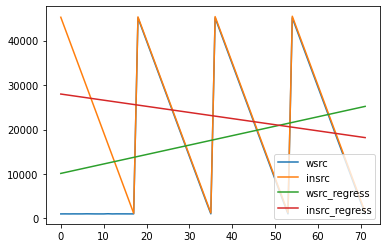

inception_layer28
wsrc cnt: 450; insrc cnt: 450; worker cnt: 50
wsrc delay: 25.0; insrc delay: 25.0; worker delay: 225.0


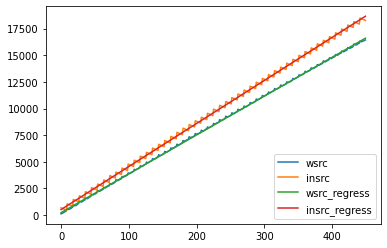

inception_layer29
wsrc cnt: 600; insrc cnt: 25; worker cnt: 600
wsrc delay: 150.0; insrc delay: 3600.0; worker delay: 150.0


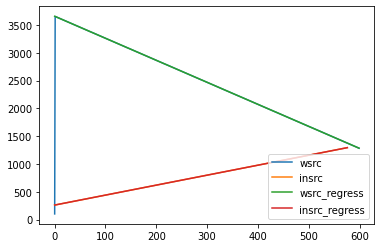

inception_layer3
wsrc cnt: 1; insrc cnt: 109; worker cnt: 109
wsrc delay: 570288.0; insrc delay: 5232.0; worker delay: 5232.0


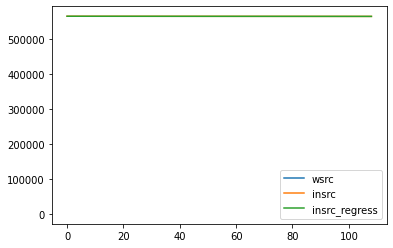

inception_layer30
wsrc cnt: 144; insrc cnt: 12; worker cnt: 144
wsrc delay: 162.0; insrc delay: 1944.0; worker delay: 162.0


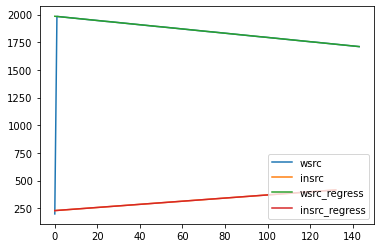

inception_layer31
wsrc cnt: 18; insrc cnt: 6; worker cnt: 18
wsrc delay: 2304.0; insrc delay: 6912.0; worker delay: 2304.0


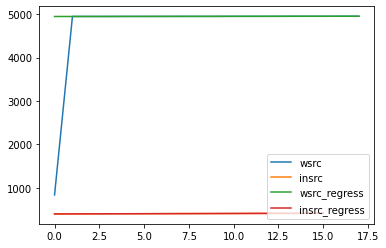

inception_layer32
wsrc cnt: 24; insrc cnt: 24; worker cnt: 12
wsrc delay: 576.0; insrc delay: 576.0; worker delay: 1152.0


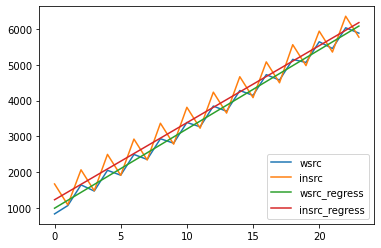

inception_layer33
wsrc cnt: 12; insrc cnt: 12; worker cnt: 6
wsrc delay: 1344.0; insrc delay: 1344.0; worker delay: 2688.0


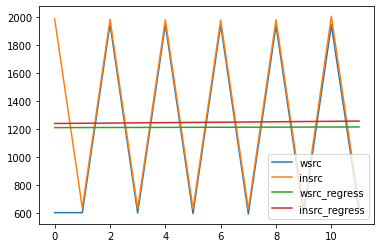

inception_layer34
wsrc cnt: 1; insrc cnt: 6; worker cnt: 6
wsrc delay: 24192.0; insrc delay: 4032.0; worker delay: 4032.0


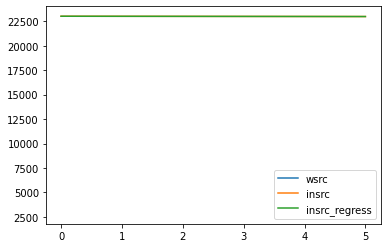

inception_layer35
wsrc cnt: 24; insrc cnt: 24; worker cnt: 12
wsrc delay: 576.0; insrc delay: 576.0; worker delay: 1152.0


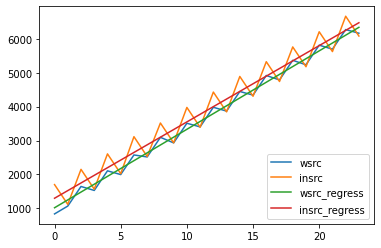

inception_layer36
wsrc cnt: 12; insrc cnt: 12; worker cnt: 6
wsrc delay: 1344.0; insrc delay: 1344.0; worker delay: 2688.0


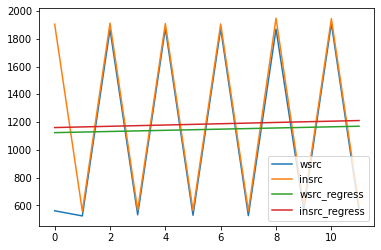

inception_layer37
wsrc cnt: 12; insrc cnt: 12; worker cnt: 6
wsrc delay: 1344.0; insrc delay: 1344.0; worker delay: 2688.0


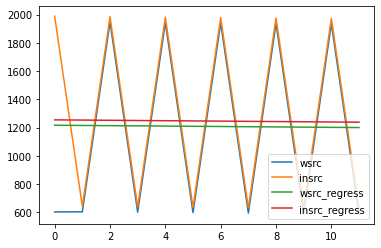

inception_layer38
wsrc cnt: 12; insrc cnt: 12; worker cnt: 6
wsrc delay: 1344.0; insrc delay: 1344.0; worker delay: 2688.0


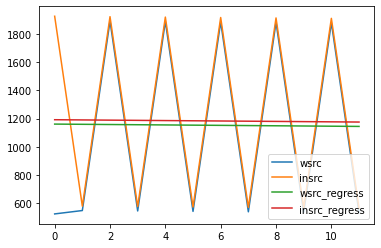

inception_layer39
wsrc cnt: 1; insrc cnt: 6; worker cnt: 6
wsrc delay: 24192.0; insrc delay: 4032.0; worker delay: 4032.0


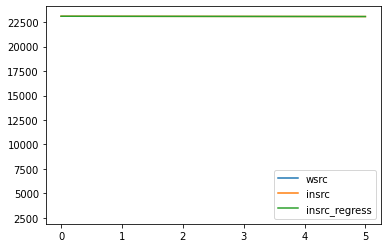

inception_layer4
wsrc cnt: 1; insrc cnt: 27; worker cnt: 27
wsrc delay: 29160.0; insrc delay: 1080.0; worker delay: 1080.0


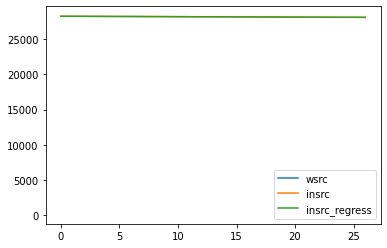

inception_layer40
wsrc cnt: 18; insrc cnt: 6; worker cnt: 18
wsrc delay: 2304.0; insrc delay: 6912.0; worker delay: 2304.0


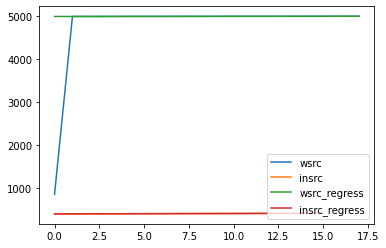

inception_layer41
wsrc cnt: 18; insrc cnt: 6; worker cnt: 18
wsrc delay: 2304.0; insrc delay: 6912.0; worker delay: 2304.0


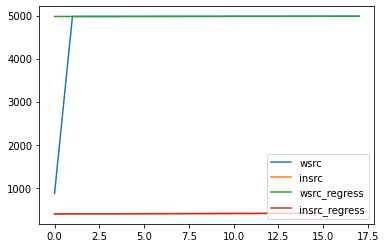

inception_layer42
wsrc cnt: 6; insrc cnt: 6; worker cnt: 3
wsrc delay: 5760.0; insrc delay: 5760.0; worker delay: 11520.0


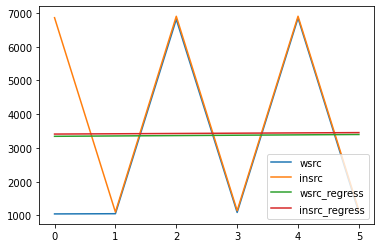

inception_layer43
wsrc cnt: 240; insrc cnt: 240; worker cnt: 24
wsrc delay: 210.0; insrc delay: 210.0; worker delay: 2100.0


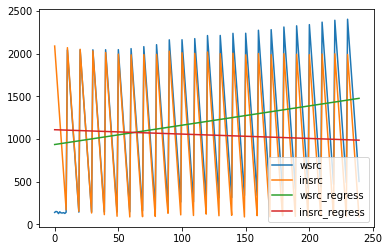

inception_layer44
wsrc cnt: 45; insrc cnt: 45; worker cnt: 9
wsrc delay: 672.0; insrc delay: 672.0; worker delay: 3360.0


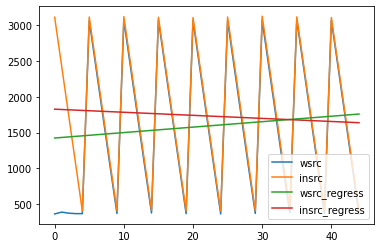

inception_layer45
wsrc cnt: 6; insrc cnt: 6; worker cnt: 3
wsrc delay: 5760.0; insrc delay: 5760.0; worker delay: 11520.0


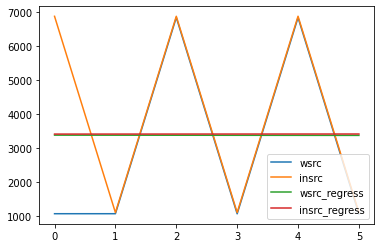

inception_layer46
wsrc cnt: 240; insrc cnt: 240; worker cnt: 24
wsrc delay: 210.0; insrc delay: 210.0; worker delay: 2100.0


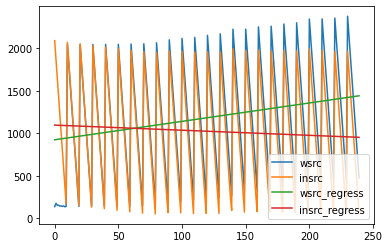

inception_layer47
wsrc cnt: 240; insrc cnt: 240; worker cnt: 24
wsrc delay: 210.0; insrc delay: 210.0; worker delay: 2100.0


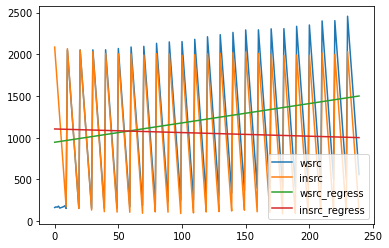

inception_layer48
wsrc cnt: 240; insrc cnt: 240; worker cnt: 24
wsrc delay: 210.0; insrc delay: 210.0; worker delay: 2100.0


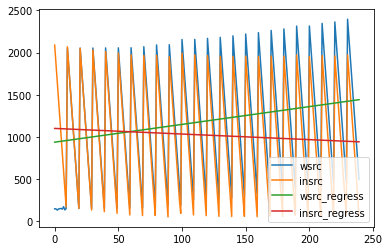

inception_layer49
wsrc cnt: 45; insrc cnt: 45; worker cnt: 9
wsrc delay: 672.0; insrc delay: 672.0; worker delay: 3360.0


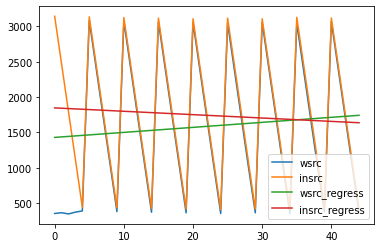

inception_layer5
wsrc cnt: 624; insrc cnt: 624; worker cnt: 624
wsrc delay: 936.0; insrc delay: 936.0; worker delay: 936.0


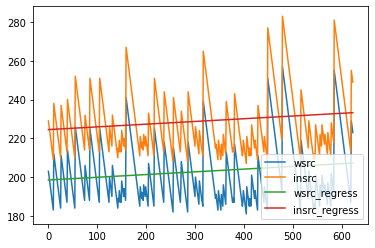

inception_layer50
wsrc cnt: 18; insrc cnt: 6; worker cnt: 18
wsrc delay: 2304.0; insrc delay: 6912.0; worker delay: 2304.0


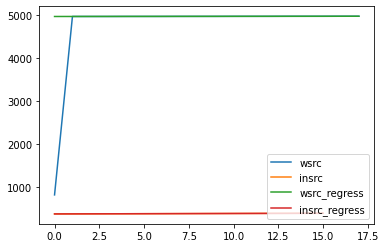

inception_layer51
wsrc cnt: 18; insrc cnt: 6; worker cnt: 18
wsrc delay: 2304.0; insrc delay: 6912.0; worker delay: 2304.0


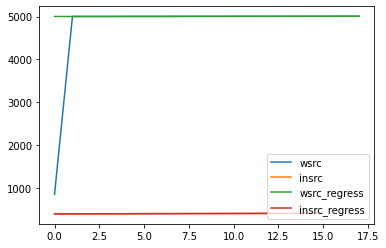

inception_layer52
wsrc cnt: 6; insrc cnt: 6; worker cnt: 3
wsrc delay: 5760.0; insrc delay: 5760.0; worker delay: 11520.0


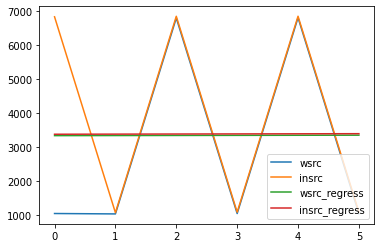

inception_layer53
wsrc cnt: 240; insrc cnt: 240; worker cnt: 24
wsrc delay: 210.0; insrc delay: 210.0; worker delay: 2100.0


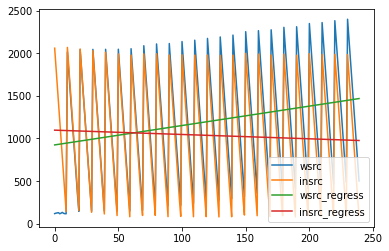

inception_layer54
wsrc cnt: 45; insrc cnt: 45; worker cnt: 9
wsrc delay: 672.0; insrc delay: 672.0; worker delay: 3360.0


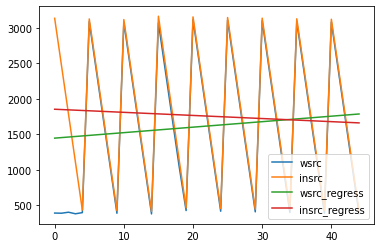

inception_layer55
wsrc cnt: 6; insrc cnt: 6; worker cnt: 3
wsrc delay: 5760.0; insrc delay: 5760.0; worker delay: 11520.0


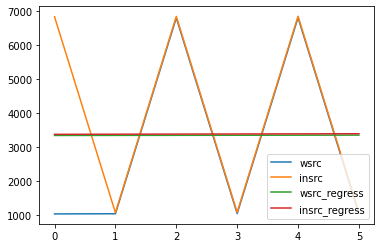

inception_layer56
wsrc cnt: 240; insrc cnt: 240; worker cnt: 24
wsrc delay: 210.0; insrc delay: 210.0; worker delay: 2100.0


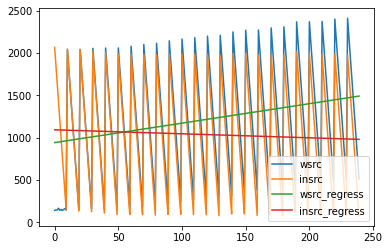

inception_layer57
wsrc cnt: 240; insrc cnt: 240; worker cnt: 24
wsrc delay: 210.0; insrc delay: 210.0; worker delay: 2100.0


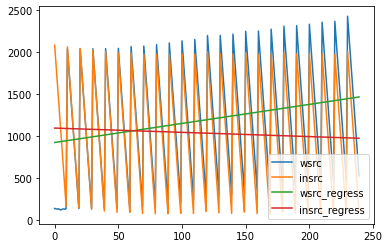

inception_layer58
wsrc cnt: 240; insrc cnt: 240; worker cnt: 24
wsrc delay: 210.0; insrc delay: 210.0; worker delay: 2100.0


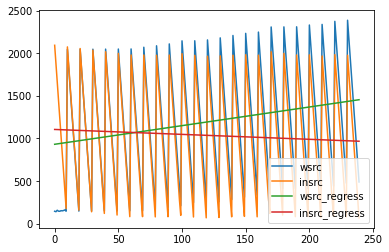

inception_layer59
wsrc cnt: 45; insrc cnt: 45; worker cnt: 9
wsrc delay: 672.0; insrc delay: 672.0; worker delay: 3360.0


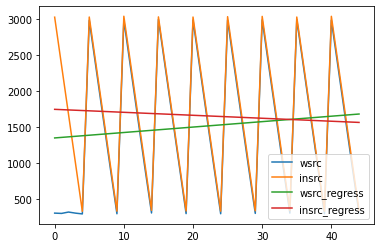

inception_layer6
wsrc cnt: 10; insrc cnt: 10; worker cnt: 5
wsrc delay: 1200.0; insrc delay: 1200.0; worker delay: 2400.0


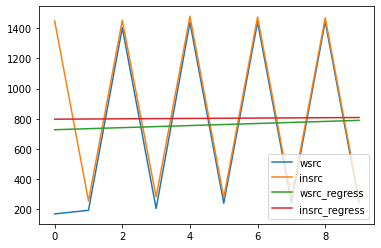

inception_layer60
wsrc cnt: 18; insrc cnt: 6; worker cnt: 18
wsrc delay: 2304.0; insrc delay: 6912.0; worker delay: 2304.0


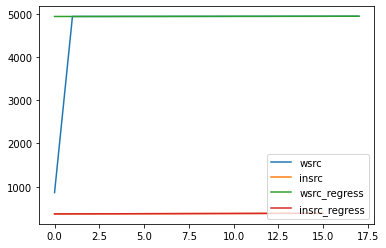

inception_layer61
wsrc cnt: 18; insrc cnt: 6; worker cnt: 18
wsrc delay: 2304.0; insrc delay: 6912.0; worker delay: 2304.0


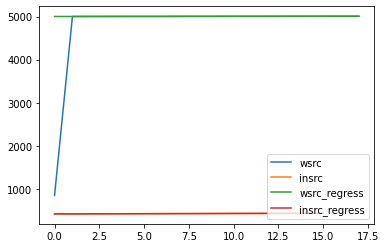

inception_layer62
wsrc cnt: 18; insrc cnt: 6; worker cnt: 18
wsrc delay: 2304.0; insrc delay: 6912.0; worker delay: 2304.0


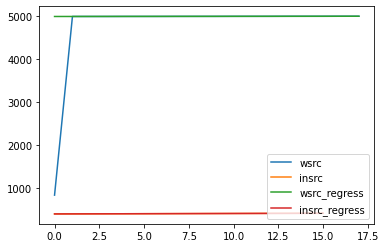

inception_layer63
wsrc cnt: 18; insrc cnt: 3; worker cnt: 18
wsrc delay: 4032.0; insrc delay: 24192.0; worker delay: 4032.0


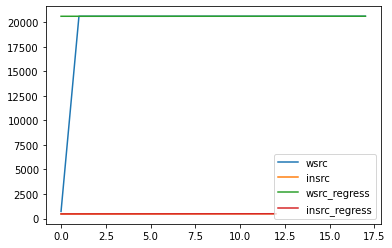

inception_layer64
wsrc cnt: 18; insrc cnt: 3; worker cnt: 18
wsrc delay: 4032.0; insrc delay: 24192.0; worker delay: 4032.0


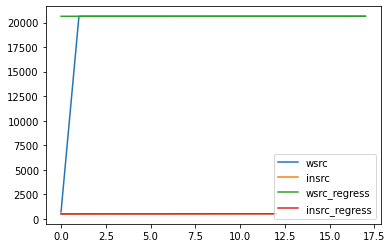

inception_layer65
wsrc cnt: 18; insrc cnt: 6; worker cnt: 18
wsrc delay: 2304.0; insrc delay: 6912.0; worker delay: 2304.0


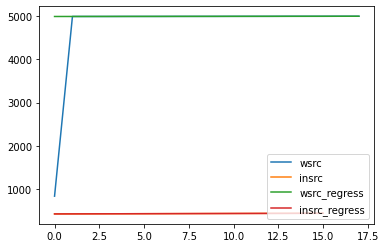

inception_layer66
wsrc cnt: 18; insrc cnt: 3; worker cnt: 18
wsrc delay: 4032.0; insrc delay: 24192.0; worker delay: 4032.0


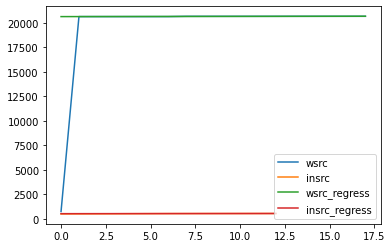

inception_layer67
wsrc cnt: 18; insrc cnt: 3; worker cnt: 18
wsrc delay: 4032.0; insrc delay: 24192.0; worker delay: 4032.0


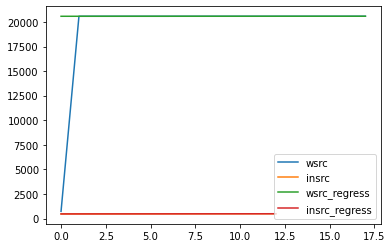

inception_layer68
wsrc cnt: 36; insrc cnt: 36; worker cnt: 12
wsrc delay: 1344.0; insrc delay: 1344.0; worker delay: 4032.0


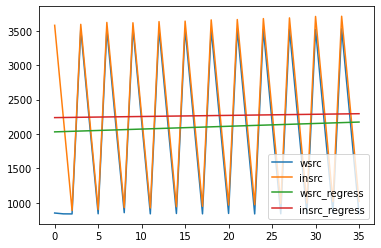

inception_layer69
wsrc cnt: 18; insrc cnt: 3; worker cnt: 18
wsrc delay: 4032.0; insrc delay: 24192.0; worker delay: 4032.0


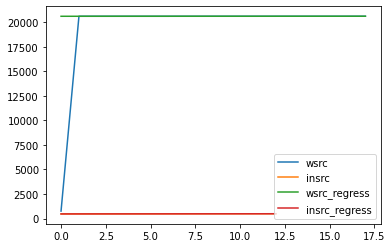

inception_layer7
wsrc cnt: 1; insrc cnt: 5; worker cnt: 5
wsrc delay: 15000.0; insrc delay: 3000.0; worker delay: 3000.0


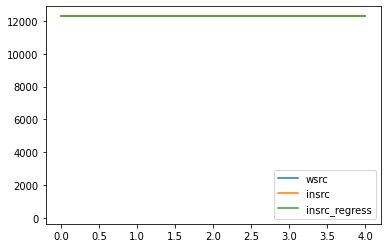

inception_layer70
wsrc cnt: 18; insrc cnt: 6; worker cnt: 18
wsrc delay: 2304.0; insrc delay: 6912.0; worker delay: 2304.0


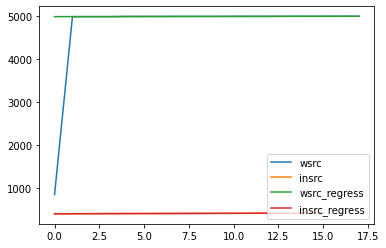

inception_layer71
wsrc cnt: 18; insrc cnt: 6; worker cnt: 18
wsrc delay: 2304.0; insrc delay: 6912.0; worker delay: 2304.0


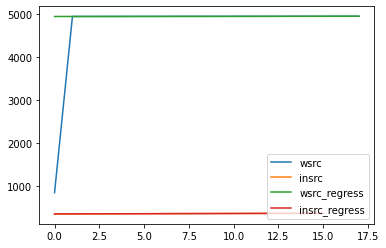

inception_layer72
wsrc cnt: 4; insrc cnt: 4; worker cnt: 4
wsrc delay: 4500.0; insrc delay: 4500.0; worker delay: 4500.0


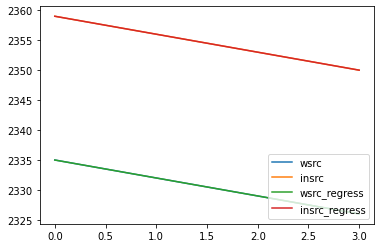

inception_layer73
wsrc cnt: 18; insrc cnt: 6; worker cnt: 18
wsrc delay: 2304.0; insrc delay: 6912.0; worker delay: 2304.0


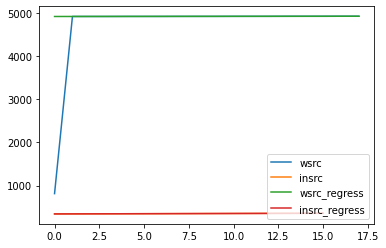

inception_layer74
wsrc cnt: 18; insrc cnt: 3; worker cnt: 18
wsrc delay: 4032.0; insrc delay: 24192.0; worker delay: 4032.0


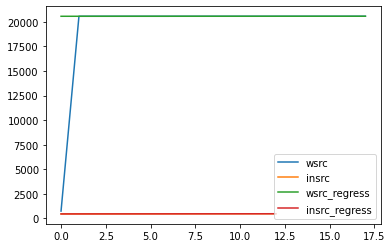

inception_layer75
wsrc cnt: 36; insrc cnt: 36; worker cnt: 12
wsrc delay: 1344.0; insrc delay: 1344.0; worker delay: 4032.0


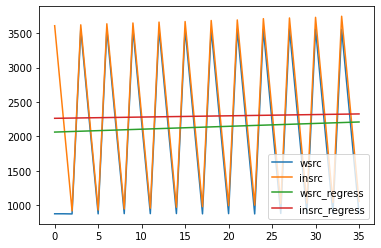

inception_layer76
wsrc cnt: 1; insrc cnt: 5; worker cnt: 5
wsrc delay: 14400.0; insrc delay: 2880.0; worker delay: 2880.0


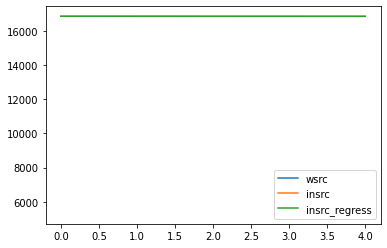

inception_layer77
wsrc cnt: 50; insrc cnt: 50; worker cnt: 50
wsrc delay: 200.0; insrc delay: 200.0; worker delay: 200.0


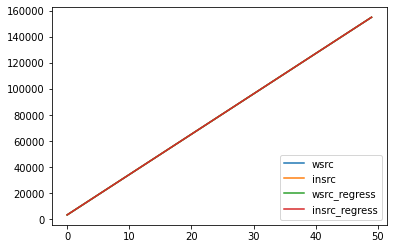

inception_layer78
wsrc cnt: 75; insrc cnt: 75; worker cnt: 15
wsrc delay: 160.0; insrc delay: 160.0; worker delay: 800.0


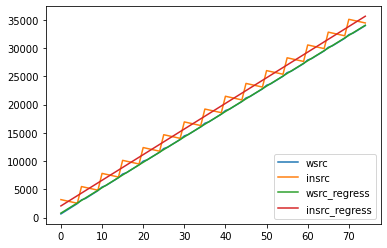

inception_layer79
wsrc cnt: 1; insrc cnt: 5; worker cnt: 5
wsrc delay: 21600.0; insrc delay: 4320.0; worker delay: 4320.0


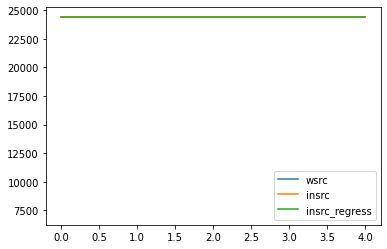

inception_layer8
wsrc cnt: 1000; insrc cnt: 1000; worker cnt: 500
wsrc delay: 250.0; insrc delay: 250.0; worker delay: 500.0


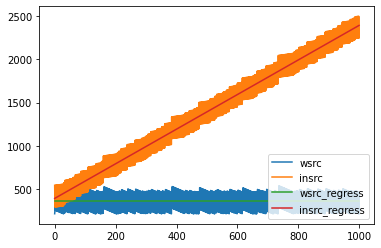

inception_layer80
wsrc cnt: 1; insrc cnt: 5; worker cnt: 5
wsrc delay: 21600.0; insrc delay: 4320.0; worker delay: 4320.0


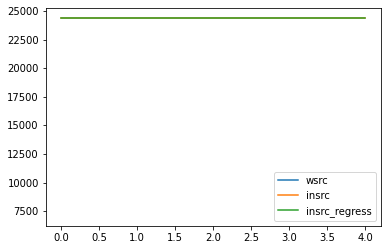

inception_layer81
wsrc cnt: 400; insrc cnt: 400; worker cnt: 100
wsrc delay: 40.0; insrc delay: 40.0; worker delay: 160.0


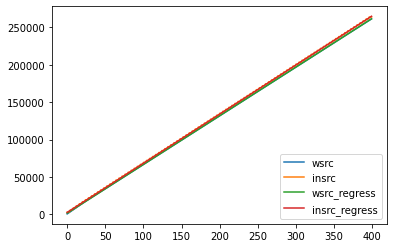

inception_layer82
wsrc cnt: 1680; insrc cnt: 1680; worker cnt: 1680
wsrc delay: 45.0; insrc delay: 45.0; worker delay: 45.0


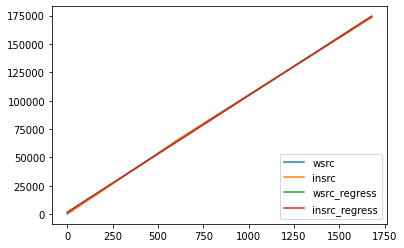

inception_layer83
wsrc cnt: 1; insrc cnt: 5; worker cnt: 5
wsrc delay: 21600.0; insrc delay: 4320.0; worker delay: 4320.0


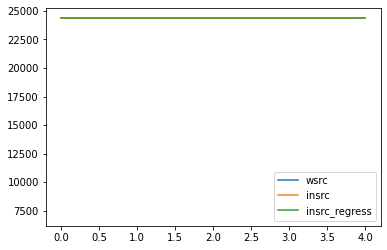

inception_layer84
wsrc cnt: 1; insrc cnt: 5; worker cnt: 5
wsrc delay: 21600.0; insrc delay: 4320.0; worker delay: 4320.0


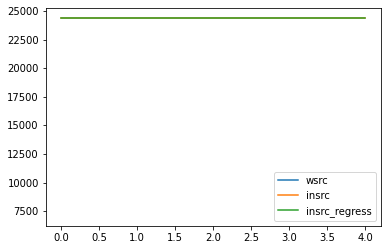

inception_layer85
wsrc cnt: 20; insrc cnt: 20; worker cnt: 5
wsrc delay: 400.0; insrc delay: 400.0; worker delay: 1600.0


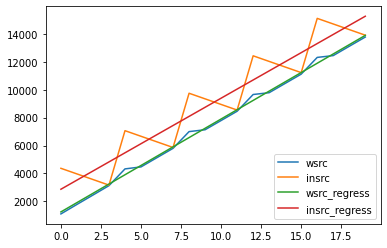

inception_layer86
wsrc cnt: 128; insrc cnt: 128; worker cnt: 2
wsrc delay: 200.0; insrc delay: 200.0; worker delay: 12800.0


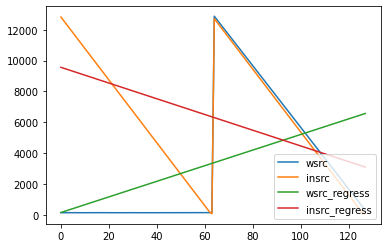

inception_layer87
wsrc cnt: 400; insrc cnt: 400; worker cnt: 25
wsrc delay: 48.0; insrc delay: 48.0; worker delay: 768.0


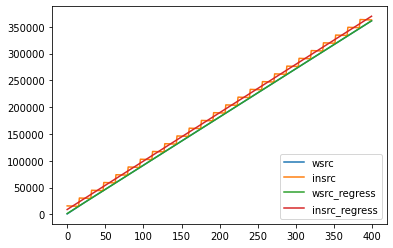

inception_layer88
wsrc cnt: 1; insrc cnt: 5; worker cnt: 5
wsrc delay: 21600.0; insrc delay: 4320.0; worker delay: 4320.0


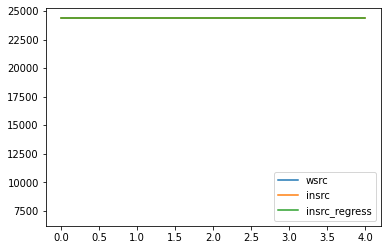

inception_layer89
wsrc cnt: 1; insrc cnt: 5; worker cnt: 5
wsrc delay: 21600.0; insrc delay: 4320.0; worker delay: 4320.0


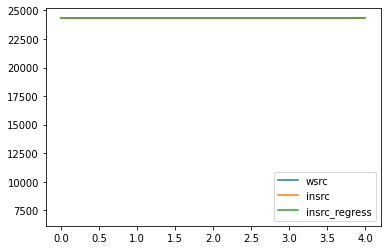

inception_layer9
wsrc cnt: 10; insrc cnt: 10; worker cnt: 5
wsrc delay: 1200.0; insrc delay: 1200.0; worker delay: 2400.0


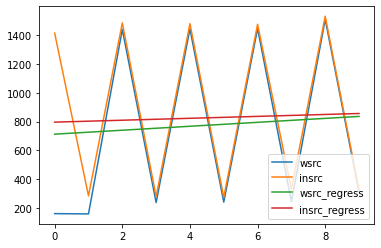

inception_layer90
wsrc cnt: 128; insrc cnt: 128; worker cnt: 2
wsrc delay: 280.0; insrc delay: 280.0; worker delay: 17920.0


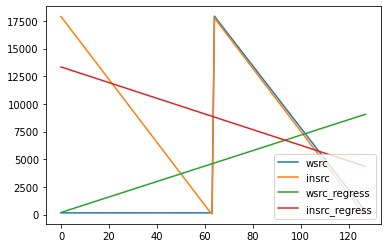

inception_layer91
wsrc cnt: 1680; insrc cnt: 1680; worker cnt: 1680
wsrc delay: 45.0; insrc delay: 45.0; worker delay: 45.0


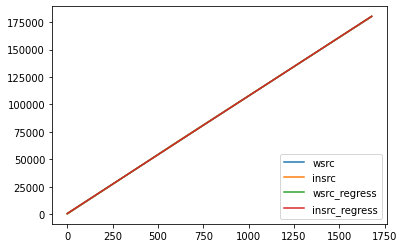

inception_layer92
wsrc cnt: 1; insrc cnt: 5; worker cnt: 5
wsrc delay: 21600.0; insrc delay: 4320.0; worker delay: 4320.0


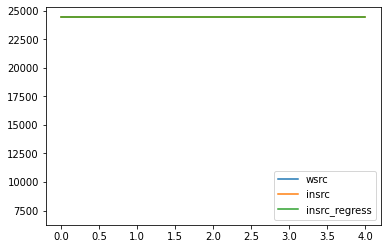

inception_layer93
wsrc cnt: 1; insrc cnt: 5; worker cnt: 5
wsrc delay: 21600.0; insrc delay: 4320.0; worker delay: 4320.0


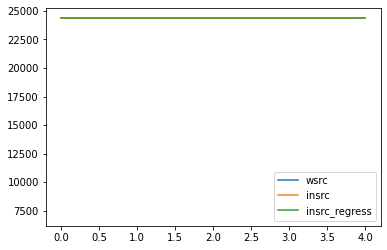

inception_layer94
wsrc cnt: 8; insrc cnt: 8; worker cnt: 8
wsrc delay: 1600.0; insrc delay: 1600.0; worker delay: 1600.0


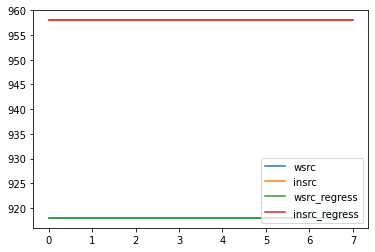

inception_layer95
wsrc cnt: 40; insrc cnt: 40; worker cnt: 40
wsrc delay: 100.0; insrc delay: 100.0; worker delay: 100.0


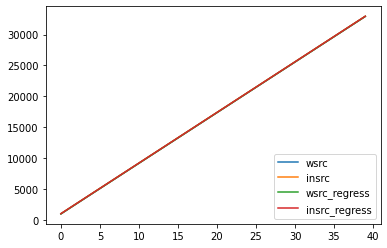

In [17]:
i = 0

for root, dirs, files in os.walk(sim_result_root):
    if len(files) < 4:
        continue  # no out.log

    taskname = os.path.split(root)[1]
    print(taskname)
    try:
        trace_analyzer = TraceAnalyzer(taskname)
    except KeyError:
        continue

    # debug
    if i < 2:
        i += 1
        continue

    for layer in sorted(trace_analyzer.get_layers()):
        w_latency, in_latency = get_real_tile_latency(trace_analyzer, layer, 0)
        w_x = np.array(list(w_latency.keys()))
        w_y = np.array(list(w_latency.values()))
        in_x = np.array(list(in_latency.keys()))
        in_y = np.array(list(in_latency.values()))
        
        plt.plot(w_x, w_y, label="wsrc")
        plt.plot(in_x, in_y, label="insrc")

        # this is still not very good when cnt is small
        # For these unusual cases, it's better to manually adjust
        if len(w_x) > 1:
            w_lin = stats.linregress(w_x[1:], w_y[1:])
            plt.plot(w_x, w_x * w_lin.slope + w_lin.intercept, label="wsrc_regress")
        if len(in_x) > 1:
            in_lin = stats.linregress(in_x[1:], in_y[1:])
            plt.plot(in_x, in_x * in_lin.slope + in_lin.intercept, label="insrc_regress")

        delay = get_delay(trace_analyzer, layer, 0)
        cnt = get_cnt(trace_analyzer, layer, 0)

        print(layer)
        print(f"wsrc cnt: {cnt['w_cnt']}; insrc cnt: {cnt['in_cnt']}; worker cnt: {cnt['worker_cnt']}")
        print(f"wsrc delay: {delay['wsrc']}; insrc delay: {delay['insrc']}; worker delay: {delay['worker']}")

        plt.legend(loc="lower right")
        plt.show()

    break

In [ ]:
for root, dirs, files in os.walk(sim_result_root):
    if len(files) < 4:
        continue  # no out.log

    taskname = os.path.split(root)[1]
    print(taskname)
    try:
        trace_analyzer = TraceAnalyzer(taskname)
    except KeyError:
        continue

    for layer in trace_analyzer.get_layers():
        res = get_real_tile_latency(trace_analyzer, layer, 0, tile=None)
        plt.plot(res)

    plt.show()
    plt.clf()